In this notebook, we are going to continue from the previous one where we had followed the approach inspired by the Bengio et al 2003 paper (https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

However, there are still a few things that we can improve upon in the previous notebook. We will be using the same dataset as before, but we will be looking at the short comings at certain points and try to improve upon them.

In [78]:
# read in our data
with open('names.txt') as f:
    words = f.read().splitlines()

len(words)

32033

In [79]:
# create a dictionary of all the characters in our dataset
chars = set(''.join(words))
ctoi = {c: i+1 for i, c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i: c for c, i in ctoi.items()}

In [80]:
# create a function to shuffle, split, and build the dataset into a training, validation, and test set

import random
import torch
import matplotlib.pyplot as plt

random.seed(42) # set the random seed for reproducibility
random.shuffle(words)

def split_dataset(train_size=0.8, val_size=0.1, test_size=0.1):
    assert train_size + val_size + test_size == 1, 'train_size + val_size + test_size must equal 1'
    train_idx = int(len(words) * train_size)
    val_idx = int(len(words) * (train_size+val_size))
    return words[:train_idx], words[train_idx:val_idx], words[val_idx:]

def build_dataset(dataset, n=3):
    X, Y = [], []
    for word in dataset:
        context = [0] * n
        for c in word + '.':
            X.append(context)
            Y.append(ctoi[c])
            context = context[1:] + [ctoi[c]]

    return torch.tensor(X), torch.tensor(Y)

In [81]:
# generate out datasets
train_dataset, val_dataset, test_dataset = split_dataset()
train_X, train_Y = build_dataset(train_dataset, n=3)
val_X, val_Y = build_dataset(val_dataset, n=3)
test_X, test_Y = build_dataset(test_dataset, n=3)

In [82]:
g = torch.Generator().manual_seed(2147483647)

In [83]:
# initialize our parameters
def init_params(emb_dims, hidden_neurons, context_size, vocab_size):
    C = torch.randn((vocab_size, emb_dims), generator=g)
    W1 = torch.randn((emb_dims*context_size, hidden_neurons), generator=g)
    b1 = torch.randn(hidden_neurons, generator=g)
    W2 = torch.randn((hidden_neurons, vocab_size), generator=g)
    b2 = torch.randn(vocab_size, generator=g)
    return [C, W1, b1, W2, b2]

In [84]:
# initialize our parameters and set requires_grad to True
params = init_params(emb_dims=10, hidden_neurons=300, context_size=3, vocab_size=len(ctoi))

for param in params:
    param.requires_grad = True

C, W1, b1, W2, b2 = params

In [85]:
print(f'Total number of parameters: {sum(param.nelement() for param in params)}')

Total number of parameters: 17697


In [86]:
# init arrays to monitor stats
train_losses = []
val_losses = []

In [87]:
batch_size = 32

lr = 0.1

# reg_strength = 0

# lets change from epochs to steps
# epochs = 40
max_steps = 200000

# max_steps = train_X.shape[0] // batch_size

We are going to change the structure of the training code to be able to look at the training more granularly at each step instead of each epoch. We have also removed tracking validation loss to speed up the training process.

In [88]:
def train_step(step):
    # construct minibatch
    idx = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = train_X[idx], train_Y[idx]

    # forward pass
    emb = C[X_batch].view(batch_size, -1) # embedding lookup
    hpreact = emb @ W1 + b1               # hidden layer pre-activation
    h = torch.tanh(hpreact)               # hidden layer activation
    logits = h @ W2 + b2                  # output layer

    loss = torch.nn.functional.cross_entropy(logits, Y_batch) # compute loss

    # backward pass
    for param in params:
        param.grad = None

    loss.backward()

    # update parameters
    lr = 0.1 if step < 100000 else 0.01
    for param in params:
        param.data -= lr * param.grad

    return emb, hpreact, h, logits, loss.item()

In [89]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (train_X, train_Y),
        'val': (val_X, val_Y),
        'test': (test_X, test_Y),
    }[split]
    emb = C[x].view(x.shape[0], -1)
    h = torch.tanh(emb @ W1 + b1)
    logits = h @ W2 + b2
    loss = torch.nn.functional.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.3f}')

      0/ 200000: train loss 34.174
  10000/ 200000: train loss 2.542
  20000/ 200000: train loss 2.779
  30000/ 200000: train loss 2.446
  40000/ 200000: train loss 2.412
  50000/ 200000: train loss 2.282
  60000/ 200000: train loss 2.753
  70000/ 200000: train loss 2.467
  80000/ 200000: train loss 2.412
  90000/ 200000: train loss 2.836
 100000/ 200000: train loss 2.326
 110000/ 200000: train loss 2.295
 120000/ 200000: train loss 1.882
 130000/ 200000: train loss 1.933
 140000/ 200000: train loss 2.082
 150000/ 200000: train loss 1.933
 160000/ 200000: train loss 2.135
 170000/ 200000: train loss 2.150
 180000/ 200000: train loss 1.650
 190000/ 200000: train loss 2.006


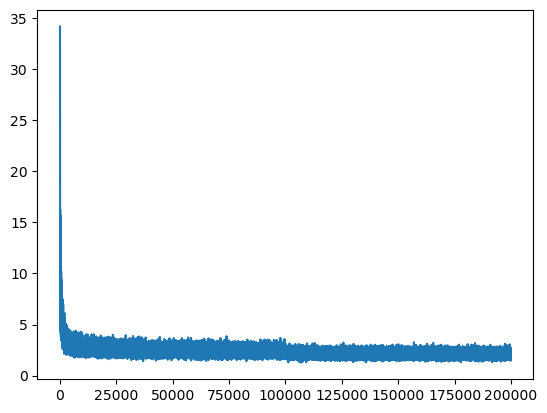

In [90]:
for step in range(max_steps):
    _, _, _, _, loss = train_step(step)
    train_losses.append(loss)

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {train_losses[-1]:.3f}')

# plot the training loss
plt.plot(train_losses, label='Training Loss')

In [91]:
split_loss('train')
split_loss('val')

train loss: 2.113
val loss: 2.177


We can notice from the training above that in the first few steps, the training loss is really high. If we analyse our model and what we are trying to achieve, we can get a better idea of what is happening. 

The model is fed a concatenated vector of the previous three characters, which is then converted into a vector in an embedding space, whose dimensionality is controlled. This embedded vector is then fed to the hidden layer, which means we multiply it with the weight matrix and add the bias. This is then passed through a tanh activation function. The output of the hidden layer is then multiplied with the output weight matrix and added to the output bias. This is then passed through a softmax activation function to get the probabilities of the next character. The loss is then calculated using the cross entropy loss function.

So the model is trying to predict the next character given the previous three characters. Which means that it can predict 1 of 27 characters. At the start of the training, the model should be predicting a character evenly, which mean ideally the loss should be log(27) = 3.295. However, we can see that the loss is much higher than that. This points towards the weights not being initialised properly, and the network being wrongly overconfident about some characters.

Let's see what our variables look like after one training step, and see how we can fix this problem.

In [92]:
# initialize our parameters and set requires_grad to True
params = init_params(emb_dims=10, hidden_neurons=300, context_size=3, vocab_size=len(ctoi))

for param in params:
    param.requires_grad = True

C, W1, b1, W2, b2 = params

train_step(0)[-1]

31.5545711517334

We know the loss should be around 3.295, but it is much higher. This means that the logits we are getting are completely wrong. The model is wrongly overconfident about some characters at the start of the training, whereas, it should be evenly confident about all the characters. This is because the weights are not initialised properly. We can fix this by initialising the weights properly. 

To better initialize the weights, and to tell the model to have a more uniform distribution of the logits, we can squash the logits so they are not extreme values. To do this we can simply multiply the weights and biases by a constant. 

In [93]:
# initialize our parameters and set requires_grad to True
params = init_params(emb_dims=10, hidden_neurons=300, context_size=3, vocab_size=len(ctoi))

C, W1, b1, W2, b2 = params

W2 *= 0.01
b2 *= 0

for param in params:
    param.requires_grad = True

train_step(0)[-1]

3.332033395767212

So we can see that by multiplying the weights and biases by a small constant, we can get the loss to be around 3.295. This is a much better starting point for the model to start training from. This way we don't waste training cycles on a bad starting point.

So lets train the model again with the new weights and biases.

      0/ 200000: train loss 3.295
  10000/ 200000: train loss 2.793
  20000/ 200000: train loss 2.403
  30000/ 200000: train loss 2.410
  40000/ 200000: train loss 2.252
  50000/ 200000: train loss 2.281
  60000/ 200000: train loss 2.292
  70000/ 200000: train loss 1.993
  80000/ 200000: train loss 2.578
  90000/ 200000: train loss 2.490
 100000/ 200000: train loss 1.816
 110000/ 200000: train loss 1.660
 120000/ 200000: train loss 1.737
 130000/ 200000: train loss 2.262
 140000/ 200000: train loss 1.876
 150000/ 200000: train loss 2.105
 160000/ 200000: train loss 2.321
 170000/ 200000: train loss 1.747
 180000/ 200000: train loss 2.211
 190000/ 200000: train loss 2.106


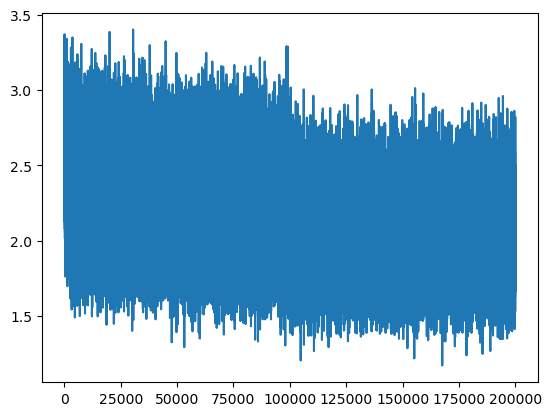

In [94]:
train_losses = []
val_losses = []

params = init_params(emb_dims=10, hidden_neurons=300, context_size=3, vocab_size=len(ctoi))

C, W1, b1, W2, b2 = params

W2 *= 0.01
b2 *= 0

for param in params:
    param.requires_grad = True

for step in range(max_steps):
    _, _, _, _, loss = train_step(step)
    train_losses.append(loss)

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {train_losses[-1]:.3f}')

# plot the training loss
plt.plot(train_losses, label='Training Loss')

In [95]:
split_loss('train')
split_loss('val')

train loss: 2.041
val loss: 2.119


We see that we don't have the hockey stick shape anymore, and the loss is much more stable. This is because the model is not overconfident about some characters at the start of the training, and is able to learn better. We also don't waste training cycles on a bad starting point, and the model doesn't have to go through a lot of iterations to get to a good starting point by squashing the weights and biases.

We have only corrected the initial loss problem by squashing the final weights and biases. However, there are weights and biases in the hidden layer as well. We can also squash those to get a better starting point for the model. We can first observe the effects of the non-squashed weights and biases on the hidden layer neurons.

In [96]:
params = init_params(emb_dims=10, hidden_neurons=300, context_size=3, vocab_size=len(ctoi))

C, W1, b1, W2, b2 = params

W2 *= 0.01
b2 *= 0

for param in params:
    param.requires_grad = True

emb, hpreact, h, logits, loss = train_step(0)

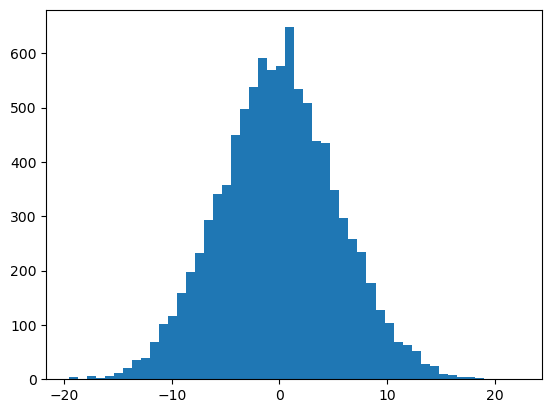

In [97]:
plt.hist(hpreact.view(-1).tolist(), 50);

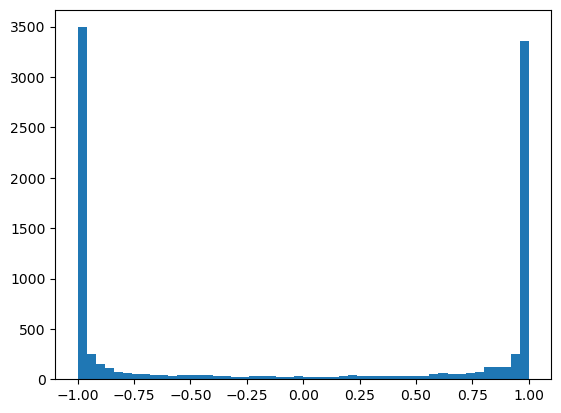

In [98]:
plt.hist(h.view(-1).tolist(), 50);

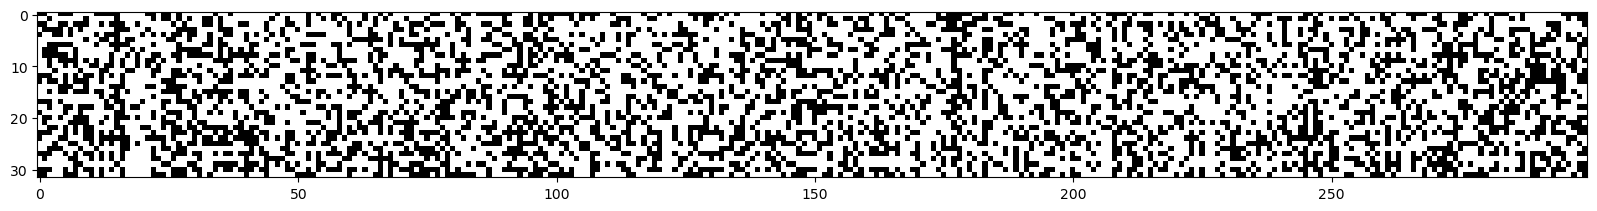

In [99]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

What the three above graphs show us is that, the hidden layer neurons are not evenly distributed. Some neurons are very active, and some are not active at all. This is because the weights and biases are not initialised properly. 

The pre-activated hidden layer neurons are the embedding vector multiplied with the hidden layer weights and added to the hidden layer biases. The post-activated hidden layer neurons are the pre-activated hidden layer neurons passed through a tanh activation function. Because the pre-active neurons have such a large spread and large values, a lot of the neurons are in the saturated region of the tanh function, which means that the neurons are either 1 or -1. This means that the neurons are not evenly distributed, and some neurons are very active, and a lot are not active at all. This distribution of the neurons being in the tail of the tanh function can be seen in the second histogram.

And when we visualize these neurons for a batch of data where we set the threshold to 0.99, we can see that a lot of the neurons are not active at all and are in the tail of the tanh function. This leads to the gradient being 0 for a lot of the neurons, which means that the model is not learning properly.

We can fix this by squashing the weights and biases in the hidden layer as well. We can do this by multiplying the weights and biases by a constant. We can observe the effects of squashing the weights and biases in the hidden layer.

In [100]:
params = init_params(emb_dims=10, hidden_neurons=300, context_size=3, vocab_size=len(ctoi))

C, W1, b1, W2, b2 = params

W1 *= 0.2
b1 *= 0.01
W2 *= 0.01
b2 *= 0

for param in params:
    param.requires_grad = True

emb, hpreact, h, logits, loss = train_step(0)

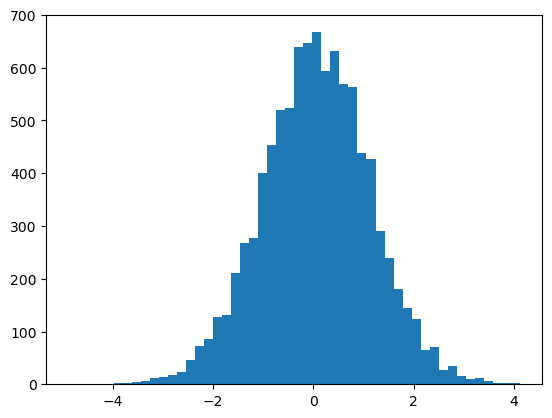

In [123]:
plt.hist(hpreact.view(-1).tolist(), 50);

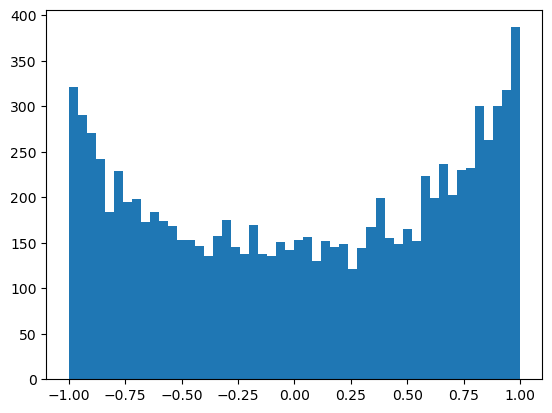

In [102]:
plt.hist(h.view(-1).tolist(), 50);

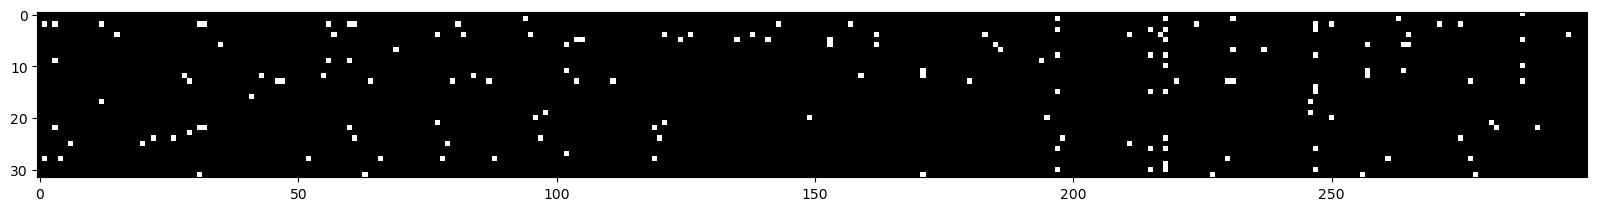

In [103]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

Now that is much better distribution of the neurons. We can see that the neurons are evenly distributed, and there are very few neurons in the tail of the tanh function for some examples. This means that the gradient is not 0 for a lot of the neurons, and the model is able to learn properly.

So let us train the model again with the new weights and biases.

      0/ 200000: train loss 3.304
  10000/ 200000: train loss 2.387
  20000/ 200000: train loss 1.715
  30000/ 200000: train loss 2.050
  40000/ 200000: train loss 2.228
  50000/ 200000: train loss 1.878
  60000/ 200000: train loss 2.206
  70000/ 200000: train loss 2.097
  80000/ 200000: train loss 2.151
  90000/ 200000: train loss 2.410
 100000/ 200000: train loss 2.380
 110000/ 200000: train loss 2.289
 120000/ 200000: train loss 1.884
 130000/ 200000: train loss 1.878
 140000/ 200000: train loss 1.686
 150000/ 200000: train loss 1.644
 160000/ 200000: train loss 2.183
 170000/ 200000: train loss 1.801
 180000/ 200000: train loss 1.924
 190000/ 200000: train loss 2.047


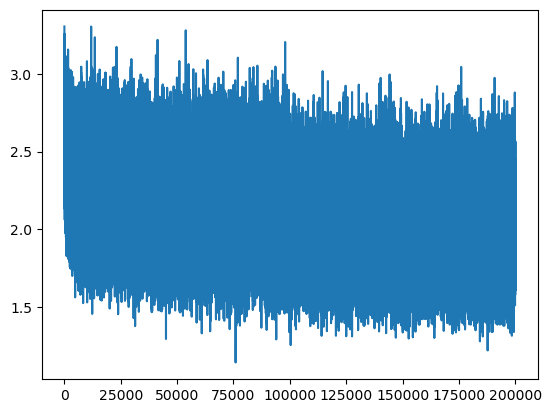

In [104]:
train_losses = []
val_losses = []

params = init_params(emb_dims=10, hidden_neurons=300, context_size=3, vocab_size=len(ctoi))

C, W1, b1, W2, b2 = params

W1 *= 0.2
b1 *= 0.01
W2 *= 0.01
b2 *= 0

for param in params:
    param.requires_grad = True

for step in range(max_steps):
    _, _, _, _, loss = train_step(step)
    train_losses.append(loss)

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {train_losses[-1]:.3f}')

# plot the training loss
plt.plot(train_losses, label='Training Loss');

In [105]:
split_loss('train')
split_loss('val')

train loss: 2.022
val loss: 2.096


So with every correction of the initialization of weights and biases, we see an improvement in the loss and the model is able to learn better. We can also see that the loss is much more stable, and we don't have the hockey stick shape anymore. This is because the model is not overconfident about some characters at the start of the training, and is able to learn better. We also don't waste training cycles on a bad starting point, and the model doesn't have to go through a lot of iterations to get to a good starting point by squashing the weights and biases.

However, to achieve this better initialization we introduced "magic" numbers. We can do better than that. We can use the Kaiming initialization to initialize the weights and biases. This is a method to initialize the weights and biases in a way that the variance of the output of each layer is the same as the variance of its input. This means that the neurons are evenly distributed, and the model is able to learn better. We can use the Kaiming initialization to initialize the weights and biases in the hidden layer and the output layer.

Using the Kaiming initialization, we multiply the weights and biases by a constant. This constant is a gain factor divided by the square root of the number of input or output neurons. The gain factor is depends on the activation function. For the tanh activation function, the gain factor is 5/3. For the ReLU activation function, the gain factor is square root of 2. For the sigmoid activation function, the gain factor is 1. For the linear activation function, the gain factor is 1.

This way there are no "magic" numbers, and we can use the same initialization for different activation functions. We can also use the same initialization for different layers.

However, the precise setting of these initializations is not necessary due to some inovations. One of these inovations is the use of batch normalization. Batch normalization is a technique to normalize the activations of the neurons in a layer. This means that the neurons are evenly distributed, and the model is able to learn better. We can use batch normalization to normalize the output of linear and convolutional layers. 

Batch normalization works by normalizing a batch of data. This is done by subtracting the mean of the batch from the batch, and dividing by the standard deviation of the batch. This is done for each neuron in the batch. This is done for each batch of data. This is done before the activation function is applied.

However, to give the model the flexibility to change the distribution of the batch of preactivations by changing the mean and standard deviation, we can also add two trainable parameters to the batch normalization. These two trainable parameters are the gain and bias parameters. The gain parameter is multiplied to the normalized batch, and the bias parameter is added to the normalized batch. This is done after the batch normalization. The gain parameter changes the standard deviation of the batch, and the bias parameter changes the mean of the batch.

We also have to introduce two extra variables to calculate a running mean and standard deviation so that we don't have to calculate the mean and standard deviation of the dataset after training to use during inference. These variables can then be used during inference to normalize the data.

In [106]:
# initialize our parameters
def init_params_bn(emb_dims, hidden_neurons, context_size, vocab_size):
    C = torch.randn((vocab_size, emb_dims), generator=g)
    W1 = torch.randn((emb_dims*context_size, hidden_neurons), generator=g)
    b1 = torch.randn(hidden_neurons, generator=g)
    W2 = torch.randn((hidden_neurons, vocab_size), generator=g)
    b2 = torch.randn(vocab_size, generator=g)

    bngain = torch.ones((1, hidden_neurons))
    bnbias = torch.zeros((1, hidden_neurons))

    return [C, W1, b1, W2, b2, bngain, bnbias]

In [107]:
train_losses = []
val_losses = []

params = init_params_bn(emb_dims=10, hidden_neurons=300, context_size=3, vocab_size=len(ctoi))

C, W1, b1, W2, b2, bngain, bnbias = params

W1 *= 0.2
b1 *= 0.01
W2 *= 0.01
b2 *= 0

for param in params:
    param.requires_grad = True

momentum = 0.001
bnmean_running = torch.zeros((1, bnbias.shape[1]))
bnstd_running = torch.ones((1, bngain.shape[1]))

In [108]:
def train_step_bn(step, bnmean_running, bnstd_running):
    # construct minibatch
    idx = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = train_X[idx], train_Y[idx]

    # forward pass
    emb = C[X_batch].view(batch_size, -1)   # embedding lookup
    hpreact = emb @ W1 + b1                 # hidden layer pre-activation

    # batch norm
    bnmean = hpreact.mean(0, keepdim=True)  # preact mean  
    bnstd = hpreact.std(0, keepdim=True)    # preact std
    hpreact_norm = bngain*((hpreact - bnmean)/bnstd) + bnbias

    with torch.no_grad():
        bnmean_running = (1-momentum)*bnmean_running + momentum*bnmean
        bnstd_running = (1-momentum)*bnstd_running + momentum*bnstd

    # non-linearity
    h = torch.tanh(hpreact_norm)                 # hidden layer activation
    logits = h @ W2 + b2                    # output layer

    loss = torch.nn.functional.cross_entropy(logits, Y_batch) # compute loss

    # backward pass
    for param in params:
        param.grad = None

    loss.backward()

    # update parameters
    lr = 0.1 if step < 100000 else 0.01
    for param in params:
        param.data -= lr * param.grad

    return emb, hpreact, hpreact_norm, h, logits, bnmean_running, bnstd_running, loss.item()

In [109]:
@torch.no_grad()
def split_loss_bn(split):
    x, y = {
        'train': (train_X, train_Y),
        'val': (val_X, val_Y),
        'test': (test_X, test_Y),
    }[split]
    emb = C[x].view(x.shape[0], -1)
    hpreact = emb @ W1 + b1
    hpreact_norm = bngain*((hpreact - bnmean_running)/bnstd_running) + bnbias
    h = torch.tanh(hpreact_norm)
    logits = h @ W2 + b2
    loss = torch.nn.functional.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.3f}')

      0/ 200000: train loss 3.308
  10000/ 200000: train loss 2.354
  20000/ 200000: train loss 2.118
  30000/ 200000: train loss 1.905
  40000/ 200000: train loss 2.333
  50000/ 200000: train loss 2.503
  60000/ 200000: train loss 2.276
  70000/ 200000: train loss 2.285
  80000/ 200000: train loss 2.177
  90000/ 200000: train loss 2.334
 100000/ 200000: train loss 2.266
 110000/ 200000: train loss 2.525
 120000/ 200000: train loss 2.068
 130000/ 200000: train loss 2.204
 140000/ 200000: train loss 2.063
 150000/ 200000: train loss 1.920
 160000/ 200000: train loss 2.167
 170000/ 200000: train loss 2.026
 180000/ 200000: train loss 1.609
 190000/ 200000: train loss 1.929


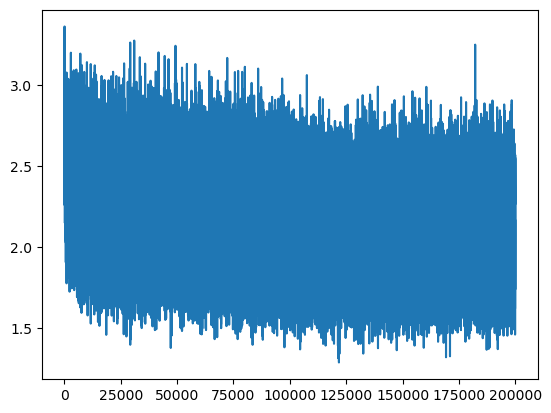

In [110]:
for step in range(max_steps):
    _, _, _, _, _, bnmean_running, bnstd_running, loss = train_step_bn(step, bnmean_running, bnstd_running)
    train_losses.append(loss)

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {train_losses[-1]:.3f}')

# plot the training loss
plt.plot(train_losses, label='Training Loss');

In [111]:
split_loss_bn('train')
split_loss_bn('val')

train loss: 2.046
val loss: 2.094


The above shows how batch normalization works. We can see that the batch normalization normalizes the batch of preactivations, and gives the model the flexibility to change the distribution of the batch of preactivations by changing the mean and standard deviation. This means that the neurons are evenly distributed, and the model is able to learn better. It also allows us to be a little more carefree with the initialization of the weights and biases. In fact, the biases in the linear layer that is followed by batch normalization can be removed. This is because bnbias parameter is learned to move the distribution.

Although the use of batch normalization provides us with this benefit, there is an interesting problem that it introduces. When applying batch normalization, we are calculating the statistics of a batch and then normalizing the batch using them which leads to coupling between examples in a batch. The logits produced from an example and similarly the gradients produced from an example are dependent on the other examples in the batch. Even though this effect is unwanted, it acts as a regularizer/data augmentation technique, causing jitter for each example depending on the other examples pulled into a batch.

In [140]:
# SUMMARY

# PyTorch-ifying the code

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # trainable params
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)

        # running statistic means
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            batch_mean = x.mean(0, keepdim=True)
            batch_var = x.var(0, keepdim=True, unbiased=True)
        else:
            batch_mean = self.running_mean
            batch_var = self.running_var

        # normalize batch
        self.out = self.gain * ((x - batch_mean) / torch.sqrt(batch_var + self.eps)) + self.bias

        if self.training:
            # update running statistics
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var

        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]
    
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

Let's first construct a model without batch normalization, and explore how carefully we have to initialize the weights and biases for such a model to learn properly. We will do this by visualizing the activations, gradients, and the updates of the weights of the parameters of the model. This will provide us with diagnostic tools and information about the model which can be used to debug the model and attempt to fix any issues.

In [156]:
n_embed = 10
n_hidden = 100
vocab_size = len(ctoi)
block_size = 3
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'{sum(p.nelement() for p in parameters)} trainable parameters')

for p in parameters:
    p.requires_grad = True

46497 trainable parameters


In [157]:
max_steps = 200000
batch_size = 32
train_losses = []
updates = []

for step in range(max_steps):

    idx = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = train_X[idx], train_Y[idx]

    # forward pass
    x = C[X_batch].view(batch_size, -1)   # embedding lookup

    for layer in layers:
        x = layer(x)

    loss = torch.nn.functional.cross_entropy(x, Y_batch) # compute loss

    for layer in layers:
        layer.out.retain_grad()

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # update parameters
    lr = 0.1 if step < 100000 else 0.01
    for param in parameters:
        param.data -= lr * param.grad

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {loss:.4f}')

    train_losses.append(loss.item())
    updates.append([(lr*p.grad.std() / p.std()).log10().item() for p in parameters])

    if step >= 1000:
        break

      0/ 200000: train loss 3.2766


Let's visualize the activations of the Tanh layers to see their distribution

layer 1 (Tanh) statistics: mean=-0.06900403648614883 | std=0.7485612034797668 | %saturated neurons=19.28125 %
layer 3 (Tanh) statistics: mean=0.009365622885525227 | std=0.7111738324165344 | %saturated neurons=11.0 %
layer 5 (Tanh) statistics: mean=0.0315435491502285 | std=0.7210162281990051 | %saturated neurons=11.78125 %
layer 7 (Tanh) statistics: mean=0.016577189788222313 | std=0.7249022722244263 | %saturated neurons=10.8125 %
layer 9 (Tanh) statistics: mean=-0.01928023062646389 | std=0.7185206413269043 | %saturated neurons=12.5625 %


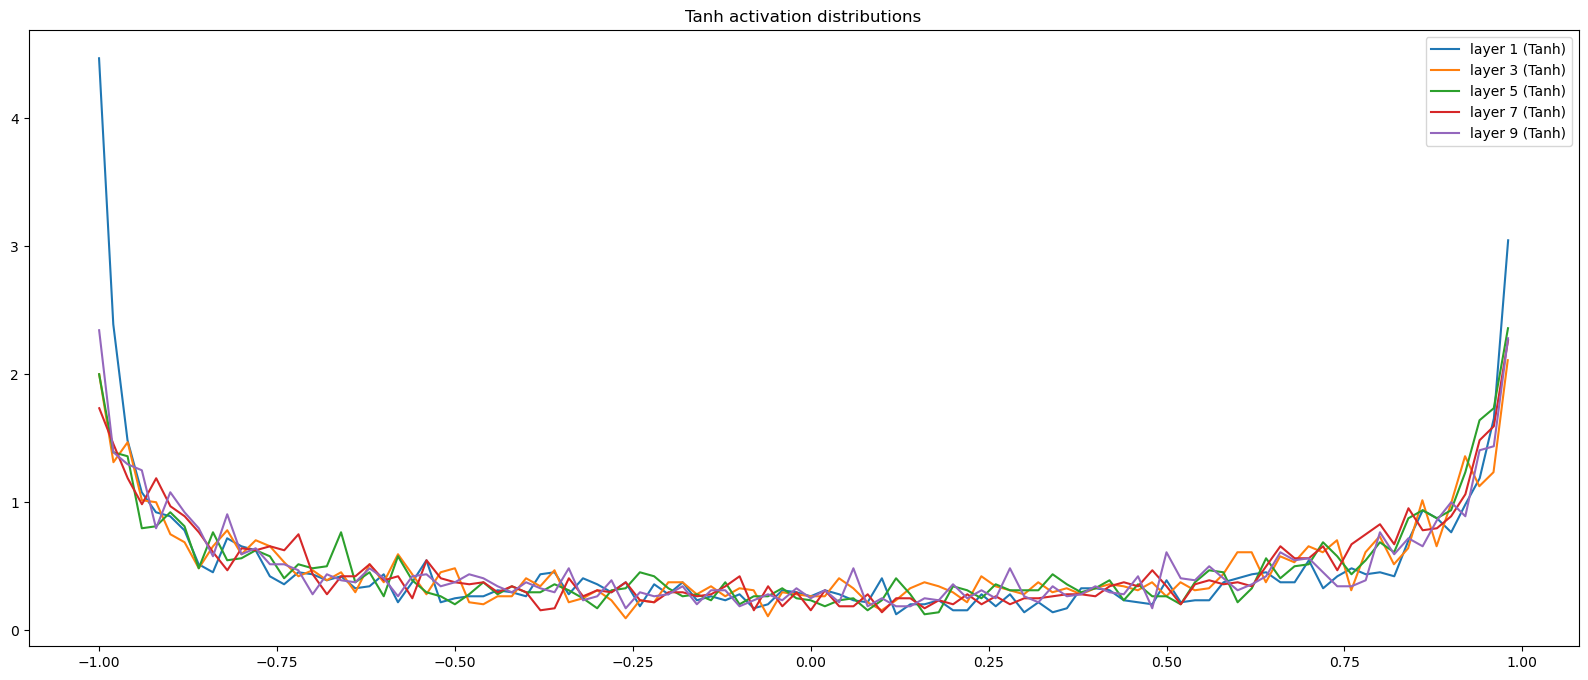

In [181]:
# plot histogram of the activations
plt.figure(figsize=(20, 8))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}) statistics: mean={t.mean()} | std={t.std()} | %saturated neurons={(t.abs() > 0.97).float().mean()*100} %')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title(f'Tanh activation distributions');

We see that the activations are evenly distributed, and there is not much saturation happening. Layer 1 has the highest number of saturated neurons. The mean and standard deviation of the activations are also stable around 0 and 0.7. This is a good sign for the activations and promotes learning. This can also be attributed to the fact that we initialized the weights using the Kaiming initialization and used the correct gain factor.

Now let's visualize the gradients of the Tanh layers to see their distribution

layer 1 (Tanh) statistics: mean=4.756454291054979e-05 | std=0.00319806975312531
layer 3 (Tanh) statistics: mean=2.0094421415706165e-05 | std=0.002937974873930216
layer 5 (Tanh) statistics: mean=2.179726470785681e-05 | std=0.002716605318710208
layer 7 (Tanh) statistics: mean=7.699456182308495e-05 | std=0.0026752157136797905
layer 9 (Tanh) statistics: mean=1.4143017779133515e-06 | std=0.0023828595876693726


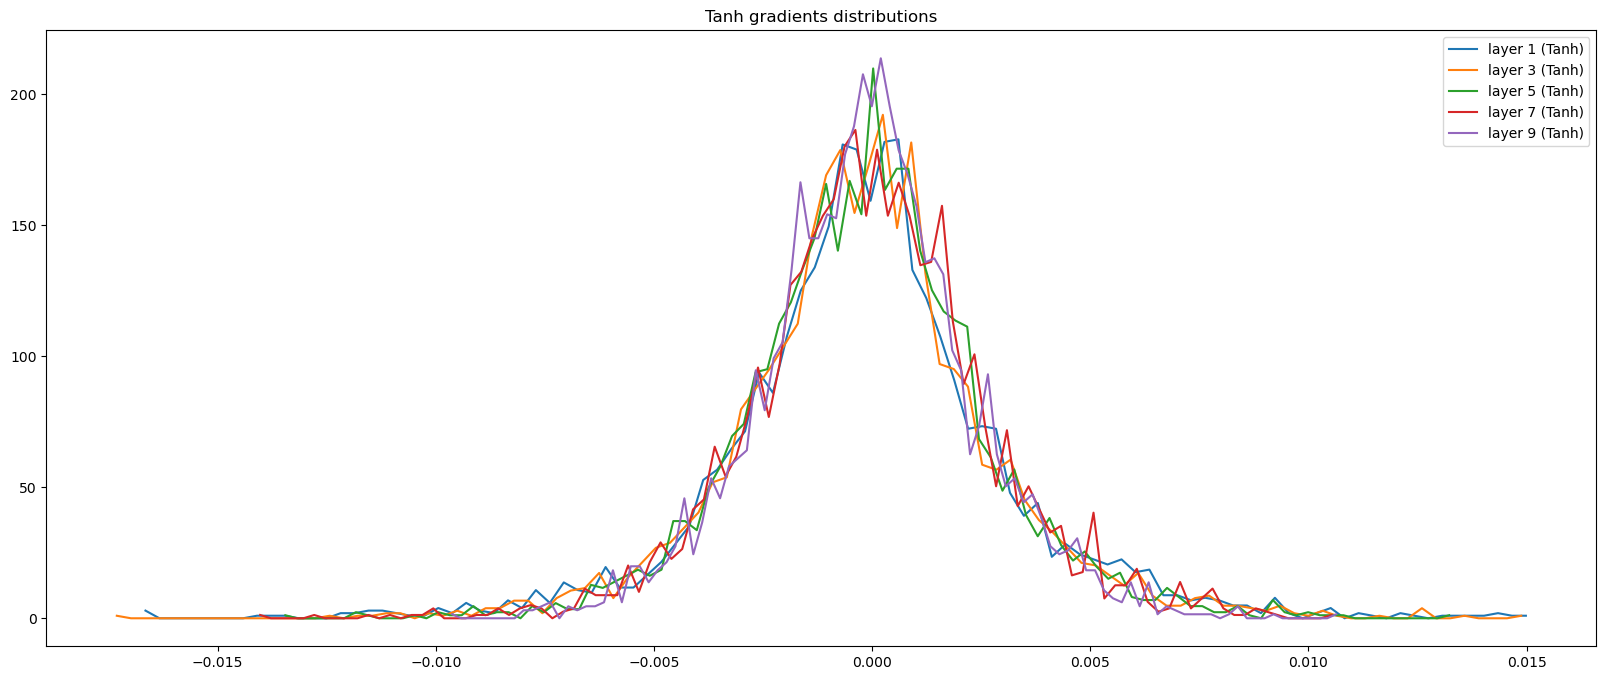

In [188]:
# plot histogram of the gradients
plt.figure(figsize=(20, 8))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}) statistics: mean={t.mean()} | std={t.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title(f'Tanh gradients distributions');

We see that the gradients are evenly distributed, but the standard deviation is small around 2e-3 and 3e-3, which means that the gradients are small. This could be bad for learning unless the learning rate is adjusted. A better indicator of learning is the updates of the weights of the parameters of the model. Let's visualize the updates of the weights of the parameters of the model to see their distribution.

Let's now visualize the gradient to data ratio of the weight matrices of the linear layers and see their distribution

weight torch.Size([27, 10]) statistics: mean=0.0006252090679481626 | std=0.012165444903075695 | grad/data=0.01215919479727745
weight torch.Size([30, 100]) statistics: mean=-4.4893872654938605e-06 | std=0.009681773371994495 | grad/data=0.03094300627708435
weight torch.Size([100, 100]) statistics: mean=-9.272612078348175e-05 | std=0.007506251335144043 | grad/data=0.044676829129457474
weight torch.Size([100, 100]) statistics: mean=8.506742597091943e-05 | std=0.006415119860321283 | grad/data=0.03786849230527878
weight torch.Size([100, 100]) statistics: mean=2.5356721380376257e-05 | std=0.0061538731679320335 | grad/data=0.03651134669780731
weight torch.Size([100, 100]) statistics: mean=-9.59602402872406e-06 | std=0.005343948025256395 | grad/data=0.0317411944270134
weight torch.Size([100, 27]) statistics: mean=-7.726527750939738e-11 | std=0.020597821101546288 | grad/data=0.2955629229545593


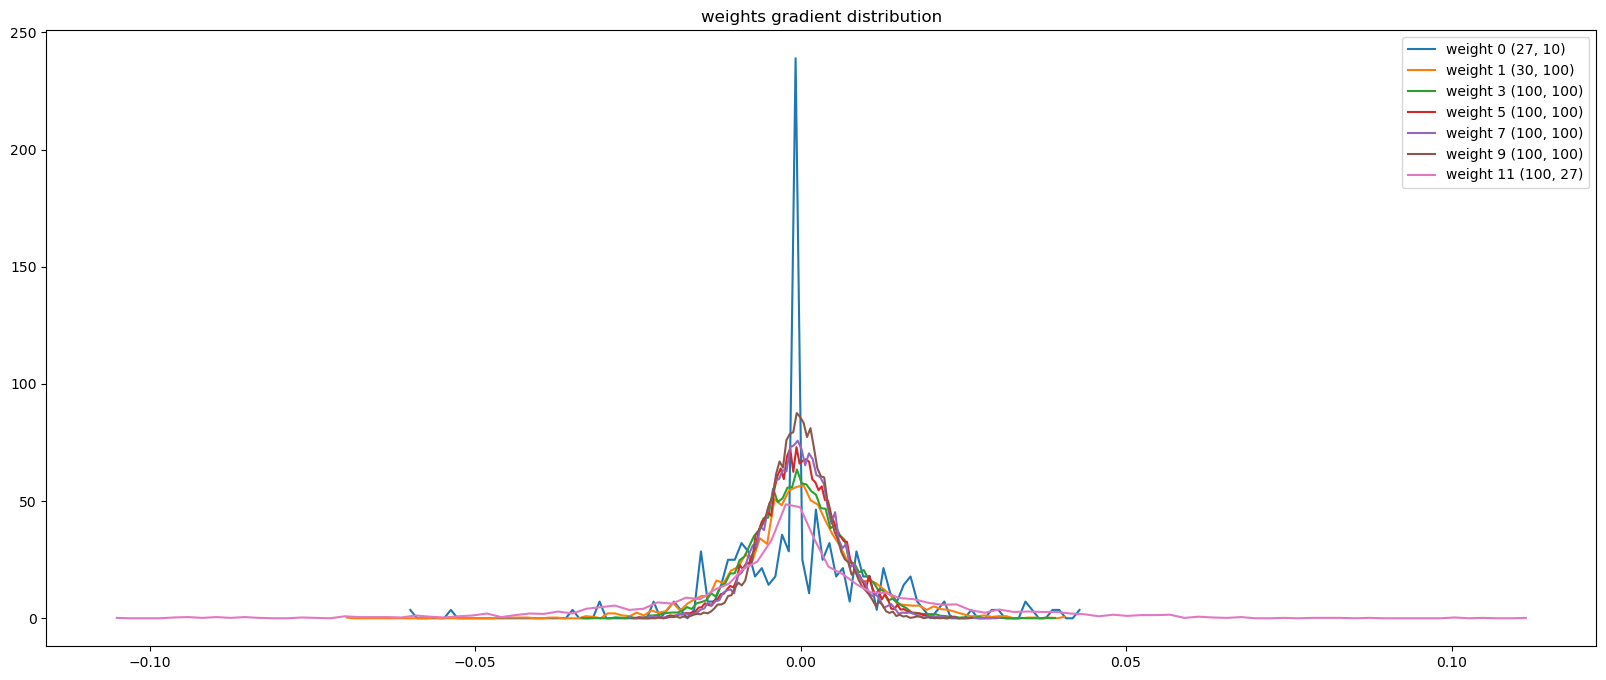

In [189]:
# plot histogram of the activations
plt.figure(figsize=(20, 8))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(f'weight {p.shape} statistics: mean={t.mean()} | std={t.std()} | grad/data={t.std()/p.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'weight {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title(f'weights gradient distribution');

We again see a nice even distribution of the gradients of the weights of the linear layers which is expected as seen from the previous graph. However, we do notice that the last linear layer has a much larger tail, and thus, a much larger standard deviation, and consequently a much larger gradient to data ratio. Due to this, during training, this layer would train much faster than the other layers.

Lastly, lets visualize the update to data ratio of the weight matrices of the linear layers and see how they change over iterations

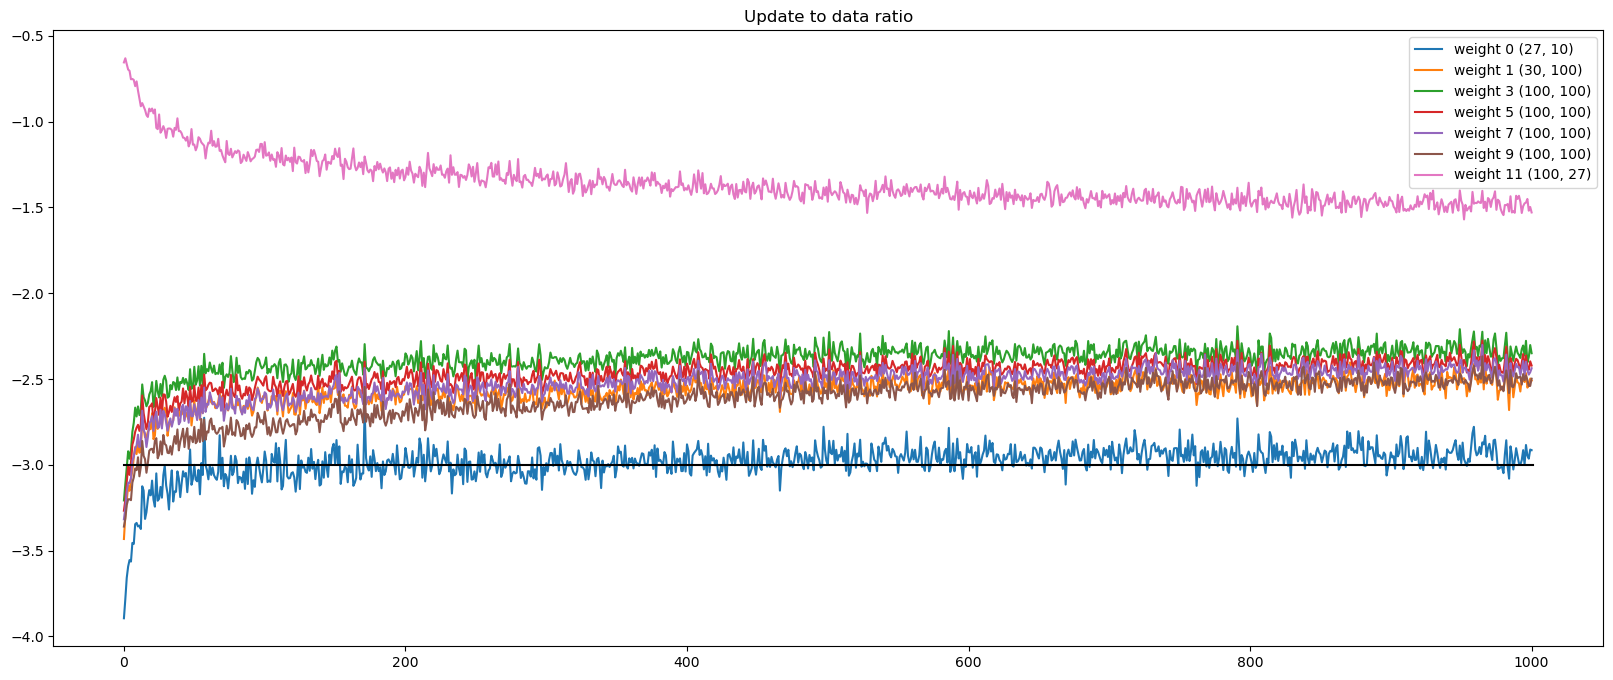

In [190]:
plt.figure(figsize=(20,8))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([updates[j][i] for j in range(len(updates))])
        legends.append(f'weight {i} {tuple(p.shape)}')
plt.plot([0, len(updates)], [-3, -3], 'k')
plt.legend(legends)
plt.title('Update to data ratio');

Here again we see that the last linear layer has a much larget update to data ratio. This is due to the fact that we artificially shrunk the last linear layer by a factor of 10 to make it less confident initially when prediciting the next character.

In general a good rule of thumb is to have the update to data ratio be around 1e-3. If the ratio is much higher or lower than this, then the learning rate should be adjusted accordingly. This is because if the ratio is much higher than 1e-3, then the model is learning too fast and the learning rate should be decreased. If the ratio is much lower than 1e-3, then the model is learning too slow and the learning rate should be increased. A fear of increasing the learning rate is that the model might diverge and get knocked off the data manifold. However, if the model is learning too slow, then it is not learning anything at all, and thus, increasing the learning rate is the only option.

This previous analysis was without the Batch Norm layer. To see the benefits of the Batch Norm layer, let's now visualize the activations of the Tanh layers to see their distribution when we do not initialize the weights and biases using the Kaiming initialization.

In [210]:
n_embed = 10
n_hidden = 100
vocab_size = len(ctoi)
block_size = 3
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.25 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'{sum(p.nelement() for p in parameters)} trainable parameters')

for p in parameters:
    p.requires_grad = True

46497 trainable parameters


In [211]:
max_steps = 200000
batch_size = 32
train_losses = []
updates = []

for step in range(max_steps):

    idx = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = train_X[idx], train_Y[idx]

    # forward pass
    x = C[X_batch].view(batch_size, -1)   # embedding lookup

    for layer in layers:
        x = layer(x)

    loss = torch.nn.functional.cross_entropy(x, Y_batch) # compute loss

    for layer in layers:
        layer.out.retain_grad()

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # update parameters
    lr = 0.1 if step < 100000 else 0.01
    for param in parameters:
        param.data -= lr * param.grad

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {loss:.4f}')

    train_losses.append(loss.item())
    updates.append([(lr*p.grad.std() / p.std()).log10().item() for p in parameters])

    if step >= 1000:
        break

      0/ 200000: train loss 3.2958


layer 1 (Tanh) statistics: mean=-0.021397745236754417 | std=0.23669873178005219 | %saturated neurons=0.0 %
layer 3 (Tanh) statistics: mean=0.0004638129030354321 | std=0.0781073048710823 | %saturated neurons=0.0 %
layer 5 (Tanh) statistics: mean=0.0003920499293599278 | std=0.03455408662557602 | %saturated neurons=0.0 %
layer 7 (Tanh) statistics: mean=-0.0012502613244578242 | std=0.05089711770415306 | %saturated neurons=0.0 %
layer 9 (Tanh) statistics: mean=-0.009483423084020615 | std=0.15839608013629913 | %saturated neurons=0.0 %


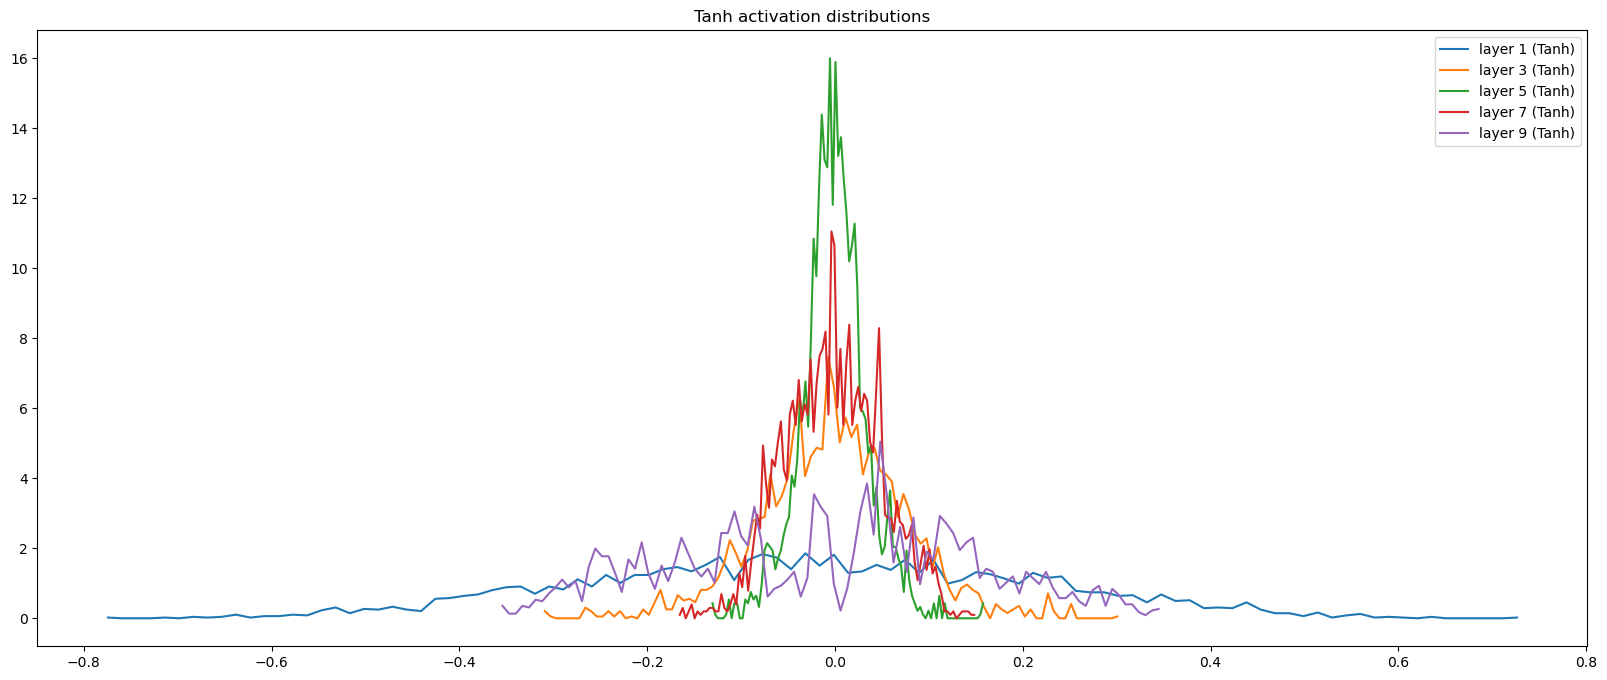

In [221]:
# plot histogram of the activations
plt.figure(figsize=(20, 8))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}) statistics: mean={t.mean()} | std={t.std()} | %saturated neurons={(t.abs() > 0.97).float().mean()*100} %')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title(f'Tanh activation distributions');

We see a lot more uneveness in the activations, and it looks like the deeper layers are less saturated and are being squashed. This is most likely due to the squashing property of the Tanh activation function.

layer 1 (Tanh) statistics: mean=1.701278961263597e-06 | std=4.964689287589863e-05
layer 3 (Tanh) statistics: mean=2.8408192065398907e-07 | std=9.374559886055067e-05
layer 5 (Tanh) statistics: mean=-2.762034910119837e-06 | std=0.00018082639144267887
layer 7 (Tanh) statistics: mean=-4.1387103522083635e-08 | std=0.0003505638742353767
layer 9 (Tanh) statistics: mean=9.369058489028248e-07 | std=0.0006003141752444208


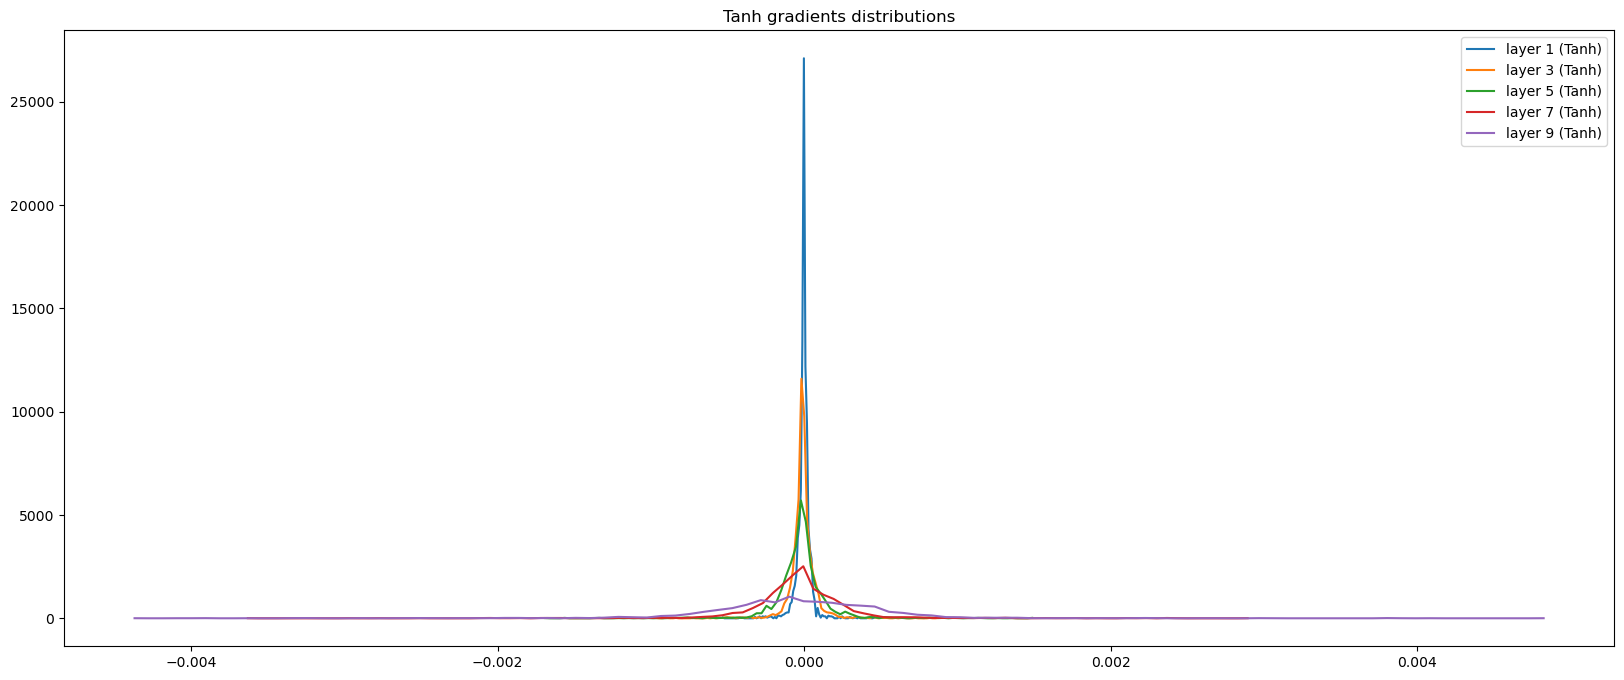

In [222]:
# plot histogram of the gradients
plt.figure(figsize=(20, 8))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}) statistics: mean={t.mean()} | std={t.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title(f'Tanh gradients distributions');

We see due to the activations being squashed, the gradients are being squashed towards 0 as well. This means that less of the gradient is passing through to the earlier layers as can be seen in the decreasing standard deviation of the gradients of the earlier layers. This will hinder learning.

weight torch.Size([27, 10]) statistics: mean=7.23656194168143e-06 | std=9.273095201933756e-05 | grad/data=9.263664105674252e-05
weight torch.Size([30, 100]) statistics: mean=-1.0800819836731534e-05 | std=0.0002550999342929572 | grad/data=0.005388661287724972
weight torch.Size([100, 100]) statistics: mean=-6.694079957014765e-07 | std=0.00014341145288199186 | grad/data=0.00567550677806139
weight torch.Size([100, 100]) statistics: mean=-5.704057457478484e-07 | std=7.262073631864041e-05 | grad/data=0.0028439161833375692
weight torch.Size([100, 100]) statistics: mean=2.687897335817979e-07 | std=5.499459075508639e-05 | grad/data=0.0021598688326776028
weight torch.Size([100, 100]) statistics: mean=-8.992915923045075e-08 | std=0.0002043278655037284 | grad/data=0.007889709435403347
weight torch.Size([100, 27]) statistics: mean=0.0 | std=0.00410026079043746 | grad/data=0.12586820125579834


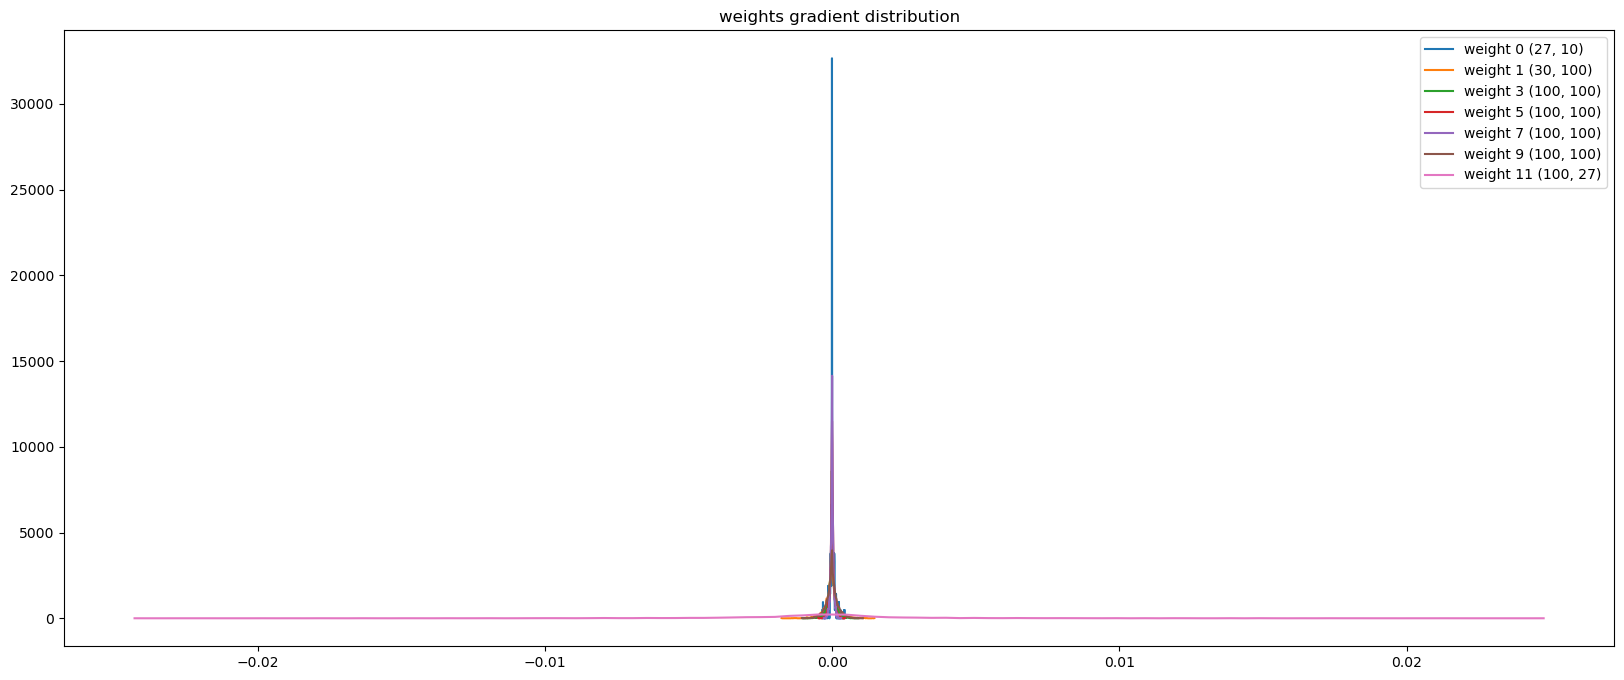

In [223]:
# plot histogram of the activations
plt.figure(figsize=(20, 8))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(f'weight {p.shape} statistics: mean={t.mean()} | std={t.std()} | grad/data={t.std()/p.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'weight {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title(f'weights gradient distribution');

Similar to the previous visualization, the earlier linear layers have a much smaller gradient to data ratio than the last linear layer.

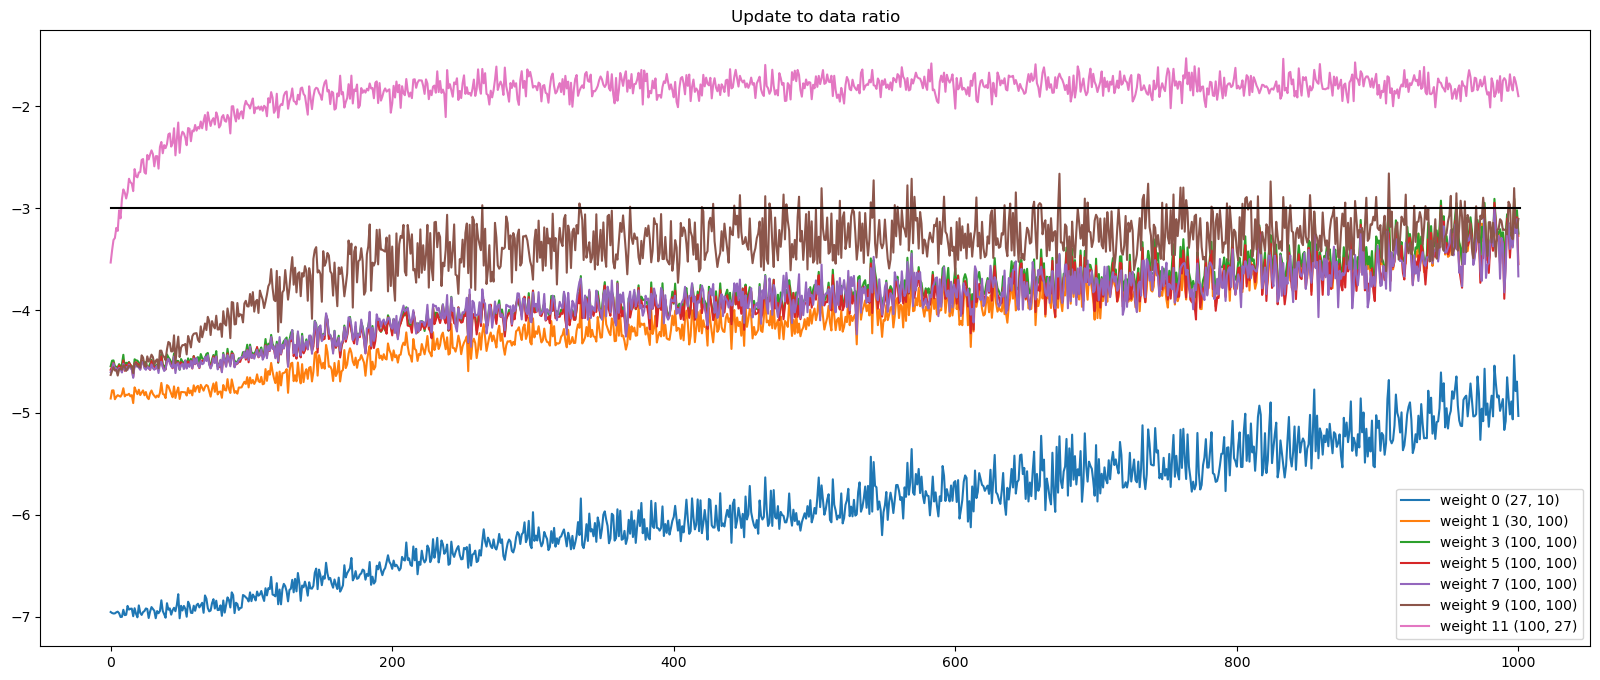

In [224]:
plt.figure(figsize=(20,8))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([updates[j][i] for j in range(len(updates))])
        legends.append(f'weight {i} {tuple(p.shape)}')
plt.plot([0, len(updates)], [-3, -3], 'k')
plt.legend(legends)
plt.title('Update to data ratio');

And we also see the different update to data ratios of the linear layers. We see that the last linear layer learns ok and is close to the desired 1e-3 benchmark. But as we go into the earlier layers, we see the updates they receive are much smaller. This is due to the fact that the gradients are being squashed towards 0, and thus, the updates are also being squashed towards 0. This will hinder learning.

This was all because we did not initialize the weights properly, and used a very small gain on purpose to show the adverse effects of not initializing the weights properly. Let's now introduce the Batch Norm layer and see how we can benefit from it.

In [225]:
n_embed = 10
n_hidden = 100
vocab_size = len(ctoi)
block_size = 3
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 0.25 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'{sum(p.nelement() for p in parameters)} trainable parameters')

for p in parameters:
    p.requires_grad = True

47497 trainable parameters


In [226]:
max_steps = 200000
batch_size = 32
train_losses = []
updates = []

for step in range(max_steps):

    idx = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = train_X[idx], train_Y[idx]

    # forward pass
    x = C[X_batch].view(batch_size, -1)   # embedding lookup

    for layer in layers:
        x = layer(x)

    loss = torch.nn.functional.cross_entropy(x, Y_batch) # compute loss

    for layer in layers:
        layer.out.retain_grad()

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # update parameters
    lr = 0.1 if step < 100000 else 0.01
    for param in parameters:
        param.data -= lr * param.grad

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {loss:.4f}')

    train_losses.append(loss.item())
    updates.append([(lr*p.grad.std() / p.std()).log10().item() for p in parameters])

    if step >= 1000:
        break

      0/ 200000: train loss 3.2813


layer 2 (Tanh) statistics: mean=0.0009707931894809008 | std=0.6449102759361267 | %saturated neurons=2.34375 %
layer 5 (Tanh) statistics: mean=-0.004481958691030741 | std=0.6544647812843323 | %saturated neurons=1.8750001192092896 %
layer 8 (Tanh) statistics: mean=-0.005007215775549412 | std=0.6594300866127014 | %saturated neurons=1.125 %
layer 11 (Tanh) statistics: mean=-0.00012171521666459739 | std=0.6659882068634033 | %saturated neurons=0.96875 %
layer 14 (Tanh) statistics: mean=0.002772384323179722 | std=0.6610487699508667 | %saturated neurons=0.4687500298023224 %


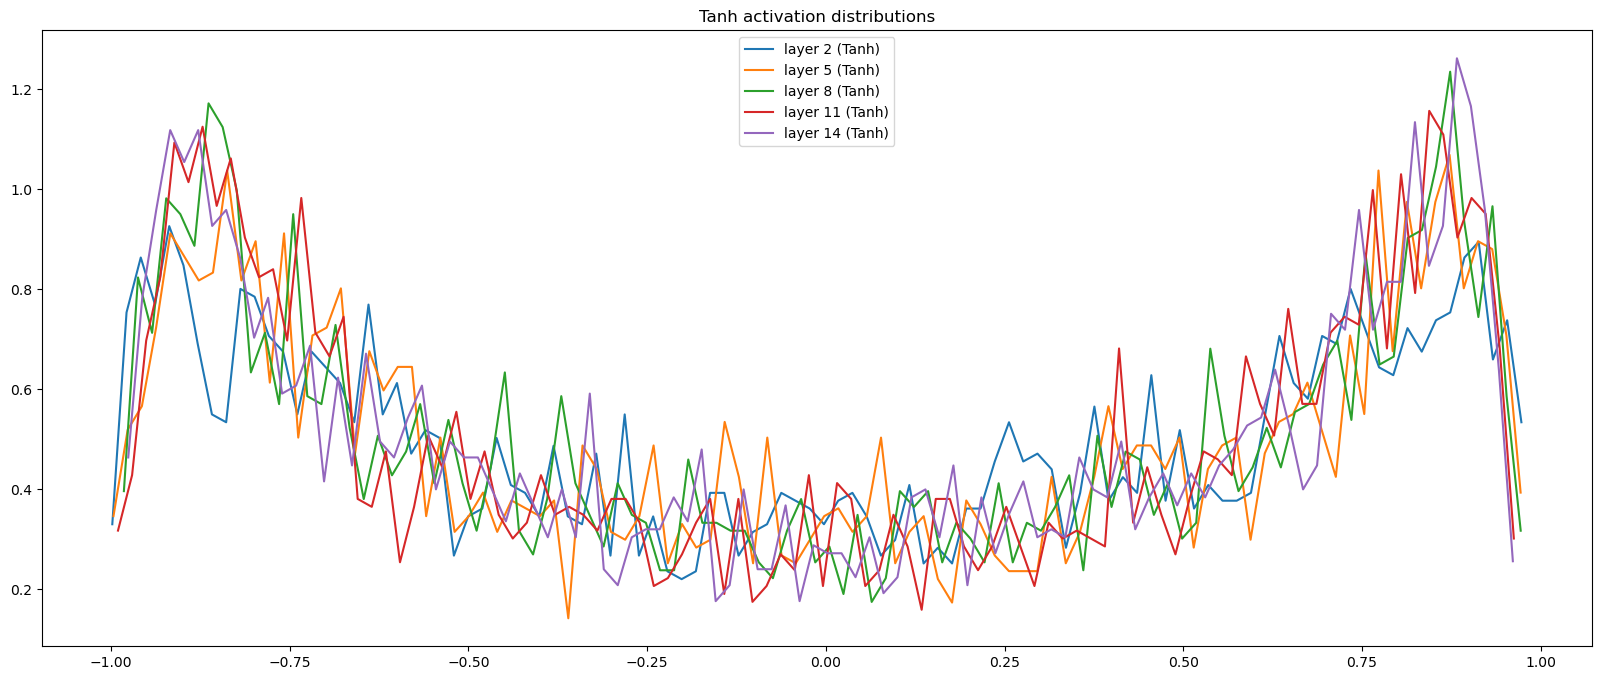

In [227]:
# plot histogram of the activations
plt.figure(figsize=(20, 8))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}) statistics: mean={t.mean()} | std={t.std()} | %saturated neurons={(t.abs() > 0.97).float().mean()*100} %')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title(f'Tanh activation distributions');

Having introduced the Batch Norm layer, we see that the activations look much better even with the improper gain initialization.

layer 2 (Tanh) statistics: mean=-7.275957614183426e-12 | std=0.0015111552784219384
layer 5 (Tanh) statistics: mean=1.746229788372744e-12 | std=0.0011254241690039635
layer 8 (Tanh) statistics: mean=0.0 | std=0.0010300894500687718
layer 11 (Tanh) statistics: mean=2.328306384496992e-12 | std=0.0010959004284814
layer 14 (Tanh) statistics: mean=2.178745126002468e-05 | std=0.0014504077844321728


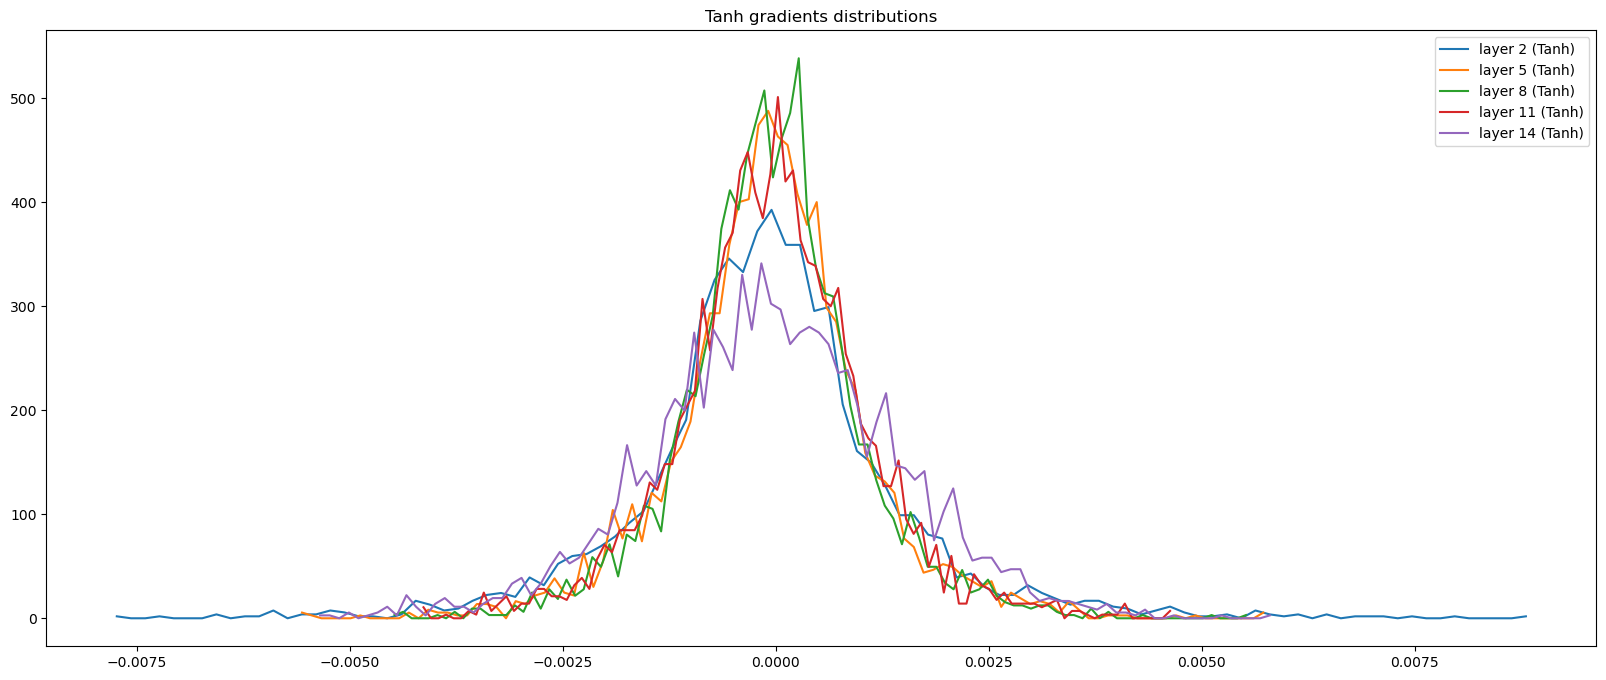

In [228]:
# plot histogram of the gradients
plt.figure(figsize=(20, 8))
legends = []

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}) statistics: mean={t.mean()} | std={t.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title(f'Tanh gradients distributions');

We see the gradients are also likewise much better even with the improper gain initialization. The earlier layers have a similar standard deviation as the last layer, and thus, the gradients are not being squashed towards 0. This will help learning.

weight torch.Size([27, 10]) statistics: mean=-2.75947424632772e-11 | std=0.010678243823349476 | grad/data=0.010665989480912685
weight torch.Size([30, 100]) statistics: mean=4.970837107975967e-05 | std=0.015196963213384151 | grad/data=0.21744109690189362
weight torch.Size([100, 100]) statistics: mean=9.741964458953589e-05 | std=0.006471189670264721 | grad/data=0.1884642392396927
weight torch.Size([100, 100]) statistics: mean=1.864725891209673e-05 | std=0.005615043453872204 | grad/data=0.17627419531345367
weight torch.Size([100, 100]) statistics: mean=1.796494507289026e-05 | std=0.0057415589690208435 | grad/data=0.18324843049049377
weight torch.Size([100, 100]) statistics: mean=7.527019624831155e-05 | std=0.0062993899919092655 | grad/data=0.1961904913187027
weight torch.Size([100, 27]) statistics: mean=8.278423085927855e-12 | std=0.018106406554579735 | grad/data=0.4028356969356537


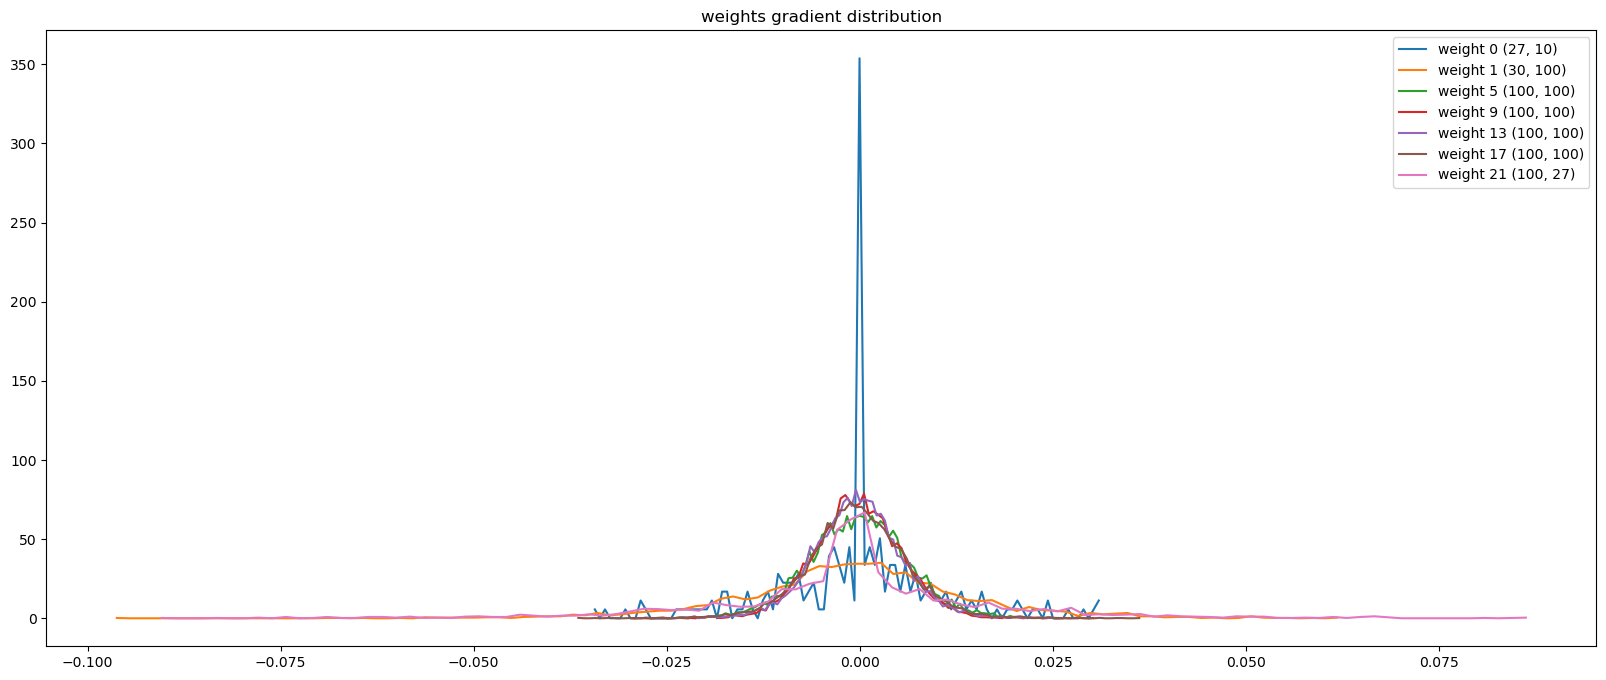

In [229]:
# plot histogram of the activations
plt.figure(figsize=(20, 8))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(f'weight {p.shape} statistics: mean={t.mean()} | std={t.std()} | grad/data={t.std()/p.std()}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'weight {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title(f'weights gradient distribution');

Even for the linear layers, we see that the gradient to data ratio is much better than before. The earlier layers have a similar gradient to data ratio as the last layer, and thus, the gradients are not being squashed towards 0. This will help learning.

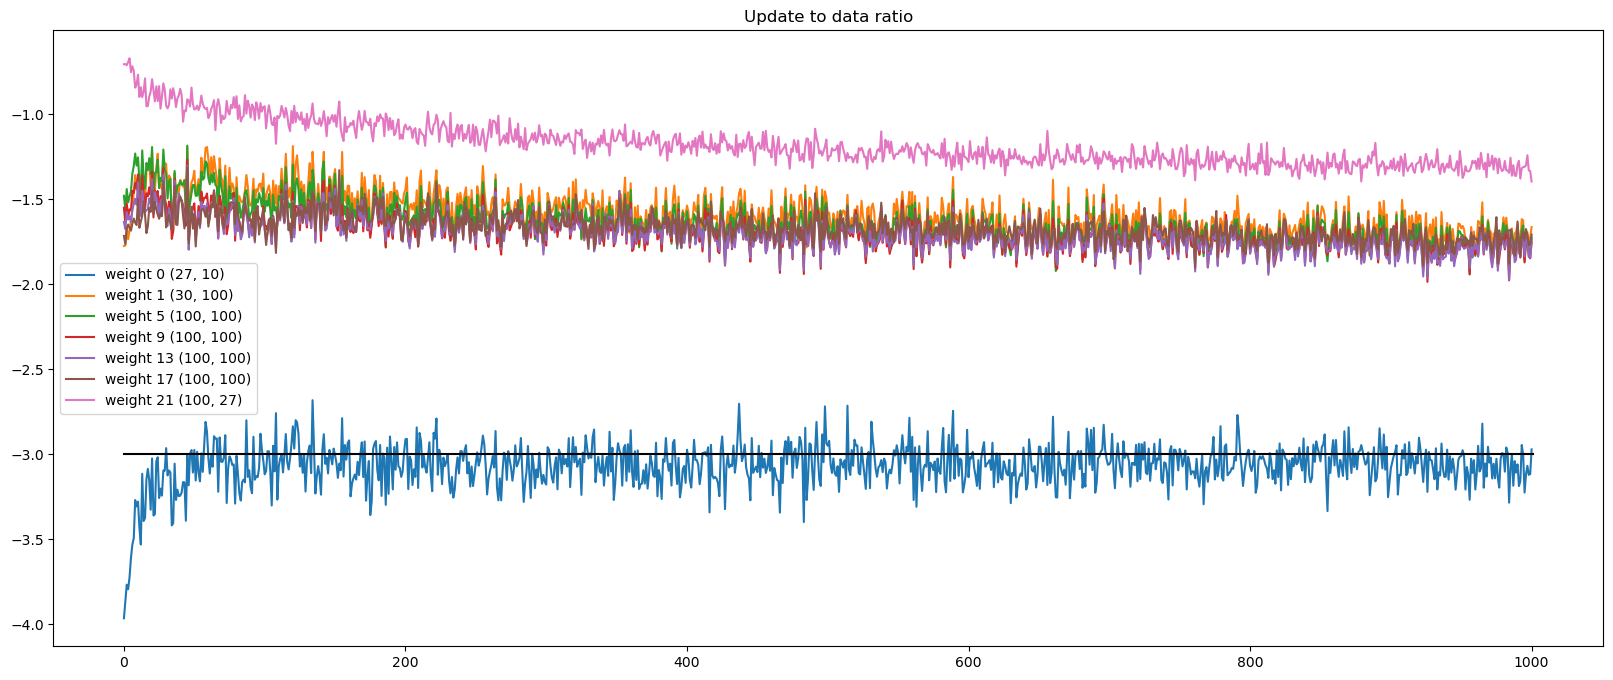

In [230]:
plt.figure(figsize=(20,8))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([updates[j][i] for j in range(len(updates))])
        legends.append(f'weight {i} {tuple(p.shape)}')
plt.plot([0, len(updates)], [-3, -3], 'k')
plt.legend(legends)
plt.title('Update to data ratio');

The only issue that arises is in the update to data ratio. We see that a lot of the layers have a much larger update to data ratio. So even though the Batch Norm layer allows us to be less precise with out initializations, we cannot be too careless. We still have to be careful with the initializations, and the gain factor should be chosen properly. This is especially true when using a simple optimizer like SGD. If we were to use a more sophisticated optimizer that uses a different learning rate for each parameter, then we could be less careful with the initializations.

In [233]:
n_embed = 10
n_hidden = 100
vocab_size = len(ctoi)
block_size = 3
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f'{sum(p.nelement() for p in parameters)} trainable parameters')

for p in parameters:
    p.requires_grad = True

47497 trainable parameters


      0/ 200000: train loss 3.2813
  10000/ 200000: train loss 2.3087
  20000/ 200000: train loss 2.1893
  30000/ 200000: train loss 1.9837
  40000/ 200000: train loss 2.1797
  50000/ 200000: train loss 2.2290
  60000/ 200000: train loss 1.8638
  70000/ 200000: train loss 2.1455
  80000/ 200000: train loss 2.2869
  90000/ 200000: train loss 1.8803
 100000/ 200000: train loss 2.3427
 110000/ 200000: train loss 2.1714
 120000/ 200000: train loss 2.0921
 130000/ 200000: train loss 2.0695
 140000/ 200000: train loss 1.6411
 150000/ 200000: train loss 1.8557
 160000/ 200000: train loss 1.9885
 170000/ 200000: train loss 1.8538
 180000/ 200000: train loss 2.2057
 190000/ 200000: train loss 1.8880


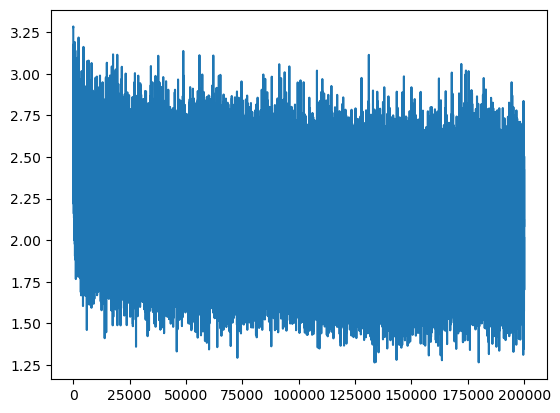

In [234]:
max_steps = 200000
batch_size = 32
train_losses = []

for step in range(max_steps):

    idx = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    X_batch, Y_batch = train_X[idx], train_Y[idx]

    # forward pass
    x = C[X_batch].view(batch_size, -1)   # embedding lookup

    for layer in layers:
        x = layer(x)

    loss = torch.nn.functional.cross_entropy(x, Y_batch) # compute loss

    # backward pass
    for param in parameters:
        param.grad = None

    loss.backward()

    # update parameters
    lr = 0.1 if step < 100000 else 0.01
    for param in parameters:
        param.data -= lr * param.grad

    if step % 10000 == 0:
        print(f'{step:7d}/{max_steps:7d}: train loss {loss:.4f}')

    train_losses.append(loss.item())

# plot the training loss
plt.plot(train_losses, label='Training Loss');

In [235]:
generator = torch.Generator().manual_seed(2147483647 + 10)

for layer in layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

for _ in range(10):
    context = [0]*3
    word = ''
    while True:
        emb = C[torch.tensor(context)]
        x = emb.view(1, -1)
        for layer in layers:
            x = layer(x)
        p = torch.nn.functional.softmax(x, dim=1)
        c = torch.multinomial(p, num_samples=1, generator=generator).item()
        if c == 0:
            break
        word += itoc[c]
        context = context[1:] + [c]
    print(word)

emerinnon
khomi
ezraylouisa
haela
leks
haiz
oluwase
maddy
tharlos
eliyah


At this point the limitation to better performance and prediction capabilities is not the optimization process, but it is the model itself. The model is not complex enough to learn the structure of the data. We are also only using a context size of 3. Therefore, we will need to increase the complexity of the model and the context size to better learn the structure of the data.

# Exercises
- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.
- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.
